# Deep Learning: MNIST
Supplemental files for the "Deep Learning" workshop, presented by the IDEA Student Center at UC San Diego.

## Requirements
- python 3.x
- numpy
- matplotlib
- keras
- tensorflow

## Goals
In this notebook, we'll compare the performance of "classic" Machine Learning methods and Deep Learning, as measured by the classification accuracy on the MNIST numerical digits data set.

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load required functionality from keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adadelta
from keras.utils import np_utils
from keras import backend as keras_backend

# make the code compatible with both Python 2 and 3
from __future__ import print_function, division

Using TensorFlow backend.


## 0) MNIST
We'll be using the MNIST data set for evaluating different classification methods. MNIST is a large database of handwritten digits (0-9) that is commonly used for training and benchmarking binary classification models.

Here's a preview of some of the MNIST samples, where each sample has a corresponding label (0-9):
<img src="mnist_samples.png" width="75%">


Before we create any models, we'll start by loading the MNIST data and viewing some sample images.

In [2]:
# download MNIST data
from keras.datasets import mnist

# split MNIST data into training and testing sets
# - training: data used to learn the model parameters
# - testing: a separate set that we will use to validate our model performance
#
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The Keras packaged did the "grunt work" for us, but it's still a good idea to check the results (i.e. not just assume everything is fine). First, let's check out some meta data about the data sets and verify that they are what we expect.

In [3]:
# check the dimensions of the data
print( X_train.shape )

(60000, 28, 28)


What do the dimensions tell us about MNIST? To better answer this, let's try viewing some of the MNIST images:

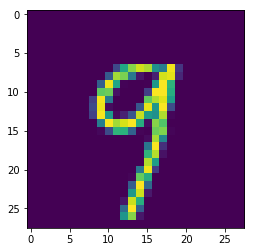

In [4]:
# select an image
img = X_train[54548]

# show the image
plt.imshow(img)
plt.show()

Notice anything about the images? For example, how many pixels are in each image?

Now that we can view the images, let's try also showing the true label alongside the image:

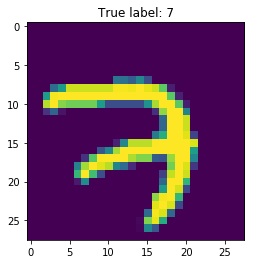

In [5]:
# select one of the images and its corresponding label
i = 5000
img = X_train[i]
label = y_train[i]

# show the image and its label
plt.imshow(img)
plt.title("True label: %d" % label)
plt.show()

## 1) Logistic regression
We'll start with a classic ML classification method (logistic regression) to get a baseline on performance.

**NOTE:** There is abundance of implementations of logistic regression (in Python and other languages). We'll use Keras to implement logistic regression simply to stay consistent.

Before we move onto models, we should pre-process the MNIST data:
1. reshape the MNIST images into 1D arrays (from 2D arrays)
2. normalize the MNIST images
3. convert the MNIST labels

Run the code below as-is to pre-process the MNIST data:

In [6]:
# load the data again (to be safe)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data: (n_samples, 28, 28) => (n_samples, 28*28)
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# convert data type and normalize the values (8-bit = 256 = 0...255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [8]:
# create the model
model = Sequential()
model.add(Dense(10, input_dim=28*28, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])            

# train the model on data
model.fit(X_train, Y_train,
          batch_size=128, # how many images to look at together
          epochs=20,       # how many epochs to run before stopping
          verbose=1,
          validation_data=(X_test, Y_test)
         )

# test the trained model on the testing set
score = model.evaluate(X_test, Y_test, verbose=0) 

print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 25us/step - loss: 1.2833 - acc: 0.7022 - val_loss: 0.8057 - val_acc: 0.8402
Epoch 2/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.7108 - acc: 0.8456 - val_loss: 0.6022 - val_acc: 0.8673
Epoch 3/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.5833 - acc: 0.8629 - val_loss: 0.5213 - val_acc: 0.8754
Epoch 4/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.5225 - acc: 0.8716 - val_loss: 0.4767 - val_acc: 0.8829
Epoch 5/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.4855 - acc: 0.8773 - val_loss: 0.4471 - val_acc: 0.8868
Epoch 6/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.4601 - acc: 0.8819 - val_loss: 0.4263 - val_acc: 0.8899
Epoch 7/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.4413 - acc: 0.8850 - val_loss: 0.4103 - val_acc

**NOTE:** Accuracy is the fraction of correct classifications of numeric digits in the MNIST testing set (e.g. 0.9 = 90% accuracy on images the model has not seen yet).

Let's look at a few results:

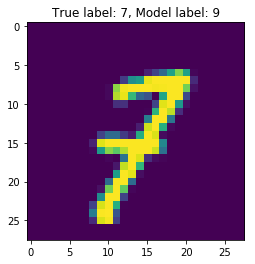

In [9]:
# select an image
i = 605
img = X_test[i].reshape(28, 28)

# prepare the image to be used in the model
x = img.reshape(-1, 28*28)

# get the model output
model_label = np.argmax( model.predict(x) )

# get the true label
true_label = np.argmax(Y_test[i])

plt.imshow(img)
plt.title('True label: {0}, Model label: {1}'.format(true_label, model_label))
plt.show()

## 2) Multilayer Perceptron (MLP)
Next we'll try out a "classic" neural network model (i.e. not a deep neural network).

A Multilayer Perceptron (aka an Artificial Neural Network) is made up of an input layer, one or more hidden layers, and an output layer:
<img src="diagram_mlp.jpg" width="50%">

In [10]:
# create the MLP model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(28*28,)))
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(10, activation='softmax'))

# print a summary of the model topology
#model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 12s 192us/step - loss: 0.3949 - acc: 0.8781 - val_loss: 0.1485 - val_acc: 0.9541
Epoch 2/4
60000/60000 [==============================] - 11s 185us/step - loss: 0.2042 - acc: 0.9422 - val_loss: 0.1236 - val_acc: 0.9647
Epoch 3/4
60000/60000 [==============================] - 11s 189us/step - loss: 0.1737 - acc: 0.9524 - val_loss: 0.1025 - val_acc: 0.9724
Epoch 4/4
60000/60000 [==============================] - 12s 204us/step - loss: 0.1554 - acc: 0.9582 - val_loss: 0.1089 - val_acc: 0.9711
Test loss: 0.108930884972
Test accuracy: 0.9711


### 2.1) Discussion
**Question 1:** How did the accuracy of the MLP model compare to the Logistic Regression model?

**Question 2:** Can you identify any other differences between the MLP and Logistic Regression models? *Hint:* Was there a difference in the code complexity and/or training time?

### 2.2) Exercises
Try to see the effects of the training and network parameters:
- learning rate
- number of training epochs
- batch size
- size of the 1st hidden layer
- size of the 2nd hidden layer

## 3) Convolutional Neural Network (CNN)
Now let's try out first deep neural network: a Convolutional Neural Network (CNN).

The CNN is made up of a few core layer types, which get stacked on top of each other:
- convolutional layers (2D)
- max pooling layers (2D)
- fully connected (aka densely connected) layers (same type as in the MLP model)

The idea is that by stacking the layers, the model is able to build up increasingly complex hierarchy of features. For example, the 1st layer may extract features corresponding to geometric primitives (e.g. lines and curves), which then feed into the next layer to form shapes (e.g. ellipsoids), and so on, until you have "recognizable" features (e.g. ears, faces and dogs).

Here's a typical CNN:
<img src="diagram_cnn.png" width="75%">

First, we need to perform pre-processing on the MNIST data, but with a slight tweak from the previous examples:

In [11]:
# load the data again (to be safe)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else:
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

# convert data type and normalize the values (8-bit = 256 = 0...255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [12]:
# create the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)
                ))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 232s 4ms/step - loss: 0.3401 - acc: 0.8965 - val_loss: 0.0800 - val_acc: 0.9752
Epoch 2/2
60000/60000 [==============================] - 214s 4ms/step - loss: 0.1150 - acc: 0.9663 - val_loss: 0.0561 - val_acc: 0.9821
Test loss: 0.0560748799725
Test accuracy: 0.9821


### 3.1) Discussion
**Question 1:** How did the accuracy of the CNN compare to the MLP and Logistic Regression models?

**Question 2:** Can you identify any other differences between the three models?

### 3.2) Exercises
Just as with the MLP model, try changing the training and network parameters to improve performance of the CNN.